# Training and Managing MNIST Predictions with SuperDuperDB

:::note
This tutorial guides you through the implementation of a classic machine learning task: MNIST handwritten digit recognition. The twist? We perform the task directly on data hosted in a database using SuperDuperDB.
:::

This example makes it easy to connect any of your image recognition models directly to your database in real-time. 

In [ ]:
!pip install torch torchvision

First, we need to establish a connection to a MongoDB datastore via SuperDuperDB. 

In [1]:
from superduperdb import superduper
    
db = superduper('mongomock://')

2024-May-24 16:42:04.28| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.base.build:69   | Data Client is ready. mongomock.MongoClient('localhost', 27017)
2024-May-24 16:42:04.30| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.base.build:42   | Connecting to Metadata Client with engine:  mongomock.MongoClient('localhost', 27017)
2024-May-24 16:42:04.30| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.base.build:155  | Connecting to compute client: None
2024-May-24 16:42:04.30| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.base.datalayer:85   | Building Data Layer
2024-May-24 16:42:04.30| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.base.build:220  | Configuration: 
 +---------------+--------------+
| Configuration |    Value     |
+---------------+--------------+
|  Data Backend | mongomock:// |
+---------------+--------------+


After establishing a connection to MongoDB, the next step is to load the MNIST dataset. SuperDuperDB's strength lies in handling diverse data types, especially those that are not supported by standard databases. To achieve this, we use an `Encoder` in conjunction with `Document` wrappers. These components allow Python dictionaries containing non-JSONable or bytes objects to be seamlessly inserted into the underlying data infrastructure.

In [2]:
import torchvision
from superduperdb import Document

import random

# Load MNIST images as Python objects using the Python Imaging Library.
# Each MNIST item is a tuple (image, label)
mnist_data = list(torchvision.datasets.MNIST(root='./data', download=True))

document_list = [Document({'img': x[0], 'class': x[1]}) for x in mnist_data]

# Shuffle the data and select a subset of 1000 documents
random.shuffle(document_list)
data = document_list[:1000]

# Insert the selected data into the mnist_collection which we mentioned before like: mnist_collection = Collection('mnist')
db['mnist'].insert_many(data[:-100]).execute()

2024-May-24 16:42:05.79| WARNING  | Duncans-MacBook-Pro.fritz.box| superduperdb.misc.annotations:117  | add is deprecated and will be removed in a future release.
2024-May-24 16:42:05.79| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:386  | Initializing DataType : dill
2024-May-24 16:42:05.79| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:389  | Initialized  DataType : dill successfully
2024-May-24 16:42:05.79| WARNING  | Duncans-MacBook-Pro.fritz.box| superduperdb.backends.local.artifacts:82   | File /tmp/e6eb888f0b0fbbab905029cb309537b9383919a6 already exists
2024-May-24 16:42:05.79| WARNING  | Duncans-MacBook-Pro.fritz.box| superduperdb.backends.local.artifacts:82   | File /tmp/ee1a946181f065af29a3c8637b2858b153d8fc8e already exists
2024-May-24 16:42:05.79| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:386  | Initializing DataType : pil_image
2024-May-24 16:42:05.79| INFO     | Duncans-MacBook-

([ObjectId('6650a73d310636ceeea3628d'),
  ObjectId('6650a73d310636ceeea3628e'),
  ObjectId('6650a73d310636ceeea3628f'),
  ObjectId('6650a73d310636ceeea36290'),
  ObjectId('6650a73d310636ceeea36291'),
  ObjectId('6650a73d310636ceeea36292'),
  ObjectId('6650a73d310636ceeea36293'),
  ObjectId('6650a73d310636ceeea36294'),
  ObjectId('6650a73d310636ceeea36295'),
  ObjectId('6650a73d310636ceeea36296'),
  ObjectId('6650a73d310636ceeea36297'),
  ObjectId('6650a73d310636ceeea36298'),
  ObjectId('6650a73d310636ceeea36299'),
  ObjectId('6650a73d310636ceeea3629a'),
  ObjectId('6650a73d310636ceeea3629b'),
  ObjectId('6650a73d310636ceeea3629c'),
  ObjectId('6650a73d310636ceeea3629d'),
  ObjectId('6650a73d310636ceeea3629e'),
  ObjectId('6650a73d310636ceeea3629f'),
  ObjectId('6650a73d310636ceeea362a0'),
  ObjectId('6650a73d310636ceeea362a1'),
  ObjectId('6650a73d310636ceeea362a2'),
  ObjectId('6650a73d310636ceeea362a3'),
  ObjectId('6650a73d310636ceeea362a4'),
  ObjectId('6650a73d310636ceeea362a5'),


Now that the images and their classes are inserted into the database, we can query the data in its original format. Particularly, we can use the `PIL.Image` instances to inspect the data.

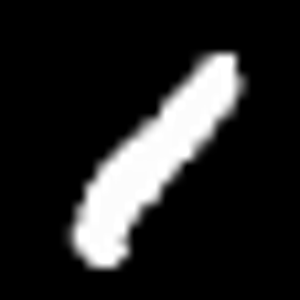

In [3]:
# Get and display one of the images
r = db['mnist'].find_one().execute()
r.unpack()['img'].resize((300, 300))

Following that, we build our machine learning model. SuperDuperDB conveniently supports various frameworks, and for this example, we opt for PyTorch, a suitable choice for computer vision tasks. In this instance, we combine `torch` with `torchvision`.

To facilitate communication with the SuperDuperDB `Datalayer`, we design `postprocess` and `preprocess` functions. These functions are then wrapped with the `TorchModel` wrapper to create a native SuperDuperDB object.

In [4]:
from superduperdb.ext.torch import TorchModel

import torch

# Define the LeNet-5 architecture for image classification
class LeNet5(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Layer 1
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Layer 2
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # Fully connected layers
        self.fc = torch.nn.Linear(400, 120)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(120, 84)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

# Postprocess function for the model output    
def postprocess(x):
    return int(x.topk(1)[1].item())

# Preprocess function for input data
def preprocess(x):
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize((32, 32)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
    )(x)

# Create an instance of the LeNet-5 model
lenet_model = LeNet5(10)


model = TorchModel(
    identifier='my-model',
    object=lenet_model,
    preprocess=preprocess,
    postprocess=postprocess, 
    preferred_devices=('cpu',),
)

# Check that the model successfully creates predictions over single data-points
model.predict_one(data[0]['img'])

2024-May-24 16:42:15.26| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:386  | Initializing TorchModel : my-model
2024-May-24 16:42:15.27| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:389  | Initialized  TorchModel : my-model successfully


2

Now we are ready to "train" or "fit" the model. Trainable models in SuperDuperDB come with a sklearn-like `.fit` method,
which developers may implement for their specific model class. `torch` models come with a pre-configured
`TorchTrainer` class and `.fit` method. These may be invoked simply by "applying" the model to `db`:

In [5]:
from torch.nn.functional import cross_entropy

from superduperdb import Metric, Validation, Dataset
from superduperdb.ext.torch import TorchTrainer

acc = lambda x, y: (sum([xx == yy for xx, yy in zip(x, y)]) / len(x))

accuracy = Metric(identifier='acc', object=acc)

model.validation = Validation(
    'mnist_performance',
    datasets=[
        Dataset(
            identifier='my-valid',
            select=db['mnist'].find({'_fold': 'valid'})
        )
    ],
    metrics=[accuracy],
)

model.trainer = TorchTrainer(
    identifier='my-trainer',
    objective=cross_entropy,
    loader_kwargs={'batch_size': 10},
    max_iterations=1000,
    validation_interval=5,
    select=db['mnist'].find(),
    key=('img', 'class'),
    transform=lambda x, y: (preprocess(x), y),
)

_ = db.apply(model)

2024-May-24 16:42:19.76| WARNING  | Duncans-MacBook-Pro.fritz.box| superduperdb.backends.local.artifacts:82   | File /tmp/a10fbf2cdd7532dd7bf5bba03b7c28e01b4326cc already exists
2024-May-24 16:42:19.79| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x110261d00>
2024-May-24 16:42:19.92| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 0; objective: 2.30452561378479; 
2024-May-24 16:42:19.94| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:386  | Initializing Dataset : my-valid
2024-May-24 16:42:19.94| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:389  | Initialized  Dataset : my-valid successfully
2024-May-24 16:42:19.94| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.components.component:386  | Initializing TorchModel : my-model
2024-May-24 16:42:19.94| INFO     | Duncans-MacBook

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 963.46it/s]


2024-May-24 16:42:19.99| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 0; my-valid/acc: 0.16279069767441862; objective: 2.3071595191955567; 
2024-May-24 16:42:20.01| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 1; objective: 2.290095806121826; 
2024-May-24 16:42:20.02| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 2; objective: 2.223555088043213; 
2024-May-24 16:42:20.02| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 3; objective: 2.3189988136291504; 
2024-May-24 16:42:20.03| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 4; objective: 2.1752736568450928; 
2024-May-24 16:42:20.03| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 5; objective

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 945.72it/s]


2024-May-24 16:42:20.09| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 5; my-valid/acc: 0.11627906976744186; objective: 2.2843324184417724; 
2024-May-24 16:42:20.11| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 6; objective: 2.282257318496704; 
2024-May-24 16:42:20.12| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 7; objective: 2.0524115562438965; 
2024-May-24 16:42:20.13| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 8; objective: 2.0606937408447266; 
2024-May-24 16:42:20.14| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 9; objective: 2.194944143295288; 
2024-May-24 16:42:20.14| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 10; objectiv

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 772.76it/s]


2024-May-24 16:42:20.22| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 10; my-valid/acc: 0.16279069767441862; objective: 2.2262439727783203; 
2024-May-24 16:42:20.25| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 11; objective: 2.1308627128601074; 
2024-May-24 16:42:20.26| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 12; objective: 2.155353307723999; 
2024-May-24 16:42:20.27| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 13; objective: 2.0958755016326904; 
2024-May-24 16:42:20.28| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 14; objective: 1.9480855464935303; 
2024-May-24 16:42:20.28| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 15; ob

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 718.64it/s]


2024-May-24 16:42:20.36| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 15; my-valid/acc: 0.3953488372093023; objective: 2.1200345516204835; 
2024-May-24 16:42:20.38| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 16; objective: 2.0746865272521973; 
2024-May-24 16:42:20.39| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 17; objective: 2.2186732292175293; 
2024-May-24 16:42:20.40| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 18; objective: 2.0799942016601562; 
2024-May-24 16:42:20.41| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 19; objective: 1.7716232538223267; 
2024-May-24 16:42:20.41| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 20; ob

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 683.64it/s]


2024-May-24 16:42:20.50| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 20; my-valid/acc: 0.4186046511627907; objective: 1.9862218618392944; 
2024-May-24 16:42:20.52| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 21; objective: 1.957564353942871; 
2024-May-24 16:42:20.53| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 22; objective: 1.8028621673583984; 
2024-May-24 16:42:20.53| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 23; objective: 1.975327491760254; 
2024-May-24 16:42:20.54| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 24; objective: 1.807953119277954; 
2024-May-24 16:42:20.55| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 25; objec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 634.74it/s]


2024-May-24 16:42:20.64| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 25; my-valid/acc: 0.4883720930232558; objective: 1.8099432945251466; 
2024-May-24 16:42:20.66| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 26; objective: 1.5425803661346436; 
2024-May-24 16:42:20.67| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 27; objective: 1.4694782495498657; 
2024-May-24 16:42:20.68| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 28; objective: 1.8224706649780273; 
2024-May-24 16:42:20.68| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 29; objective: 1.5353931188583374; 
2024-May-24 16:42:20.69| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 30; ob

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 748.24it/s]


2024-May-24 16:42:20.78| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 30; my-valid/acc: 0.5116279069767442; objective: 1.6320355653762817; 
2024-May-24 16:42:20.80| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 31; objective: 1.4210201501846313; 
2024-May-24 16:42:20.81| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 32; objective: 1.8781251907348633; 
2024-May-24 16:42:20.82| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 33; objective: 1.166929841041565; 
2024-May-24 16:42:20.83| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 34; objective: 1.6172298192977905; 
2024-May-24 16:42:20.84| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 35; obj

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 759.59it/s]


2024-May-24 16:42:20.91| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 35; my-valid/acc: 0.6744186046511628; objective: 1.450360083580017; 
2024-May-24 16:42:20.93| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 36; objective: 1.544428825378418; 
2024-May-24 16:42:20.94| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 37; objective: 1.4825594425201416; 
2024-May-24 16:42:20.95| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 38; objective: 1.481727957725525; 
2024-May-24 16:42:20.96| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 39; objective: 1.5011167526245117; 
2024-May-24 16:42:20.96| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 40; objec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 825.43it/s]


2024-May-24 16:42:21.03| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 40; my-valid/acc: 0.5813953488372093; objective: 1.3515176057815552; 
2024-May-24 16:42:21.06| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 41; objective: 1.137115240097046; 
2024-May-24 16:42:21.07| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 42; objective: 1.2611033916473389; 
2024-May-24 16:42:21.07| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 43; objective: 1.5822103023529053; 
2024-May-24 16:42:21.08| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 44; objective: 0.9167646169662476; 
2024-May-24 16:42:21.09| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 45; obj

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 677.50it/s]


2024-May-24 16:42:21.17| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 45; my-valid/acc: 0.5813953488372093; objective: 1.2751734495162963; 
2024-May-24 16:42:21.19| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 46; objective: 1.5230745077133179; 
2024-May-24 16:42:21.20| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 47; objective: 0.9670822024345398; 
2024-May-24 16:42:21.21| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 48; objective: 1.2309763431549072; 
2024-May-24 16:42:21.22| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 49; objective: 1.4959913492202759; 
2024-May-24 16:42:21.22| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 50; ob

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 702.56it/s]


2024-May-24 16:42:21.31| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 50; my-valid/acc: 0.5813953488372093; objective: 1.1450695395469666; 
2024-May-24 16:42:21.33| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 51; objective: 0.9896019101142883; 
2024-May-24 16:42:21.33| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 52; objective: 1.0472078323364258; 
2024-May-24 16:42:21.35| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 53; objective: 0.6146770715713501; 
2024-May-24 16:42:21.35| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 54; objective: 1.223360300064087; 
2024-May-24 16:42:21.36| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 55; obj

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 624.73it/s]


2024-May-24 16:42:21.45| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 55; my-valid/acc: 0.5116279069767442; objective: 1.1396703839302063; 
2024-May-24 16:42:21.47| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 56; objective: 0.8977691531181335; 
2024-May-24 16:42:21.48| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 57; objective: 1.013144850730896; 
2024-May-24 16:42:21.48| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 58; objective: 0.7408015131950378; 
2024-May-24 16:42:21.49| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 59; objective: 0.662105143070221; 
2024-May-24 16:42:21.49| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 60; obje

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 735.76it/s]


2024-May-24 16:42:21.57| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 60; my-valid/acc: 0.7209302325581395; objective: 0.8712847888469696; 
2024-May-24 16:42:21.59| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 61; objective: 0.8210352063179016; 
2024-May-24 16:42:21.60| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 62; objective: 0.8280698657035828; 
2024-May-24 16:42:21.61| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 63; objective: 0.6546609401702881; 
2024-May-24 16:42:21.62| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 64; objective: 0.6739475727081299; 
2024-May-24 16:42:21.63| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 65; ob

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 674.51it/s]


2024-May-24 16:42:21.71| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 65; my-valid/acc: 0.7441860465116279; objective: 0.8647180676460267; 
2024-May-24 16:42:21.73| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 66; objective: 0.8211454153060913; 
2024-May-24 16:42:21.74| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 67; objective: 0.7842769622802734; 
2024-May-24 16:42:21.75| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 68; objective: 0.5703445672988892; 
2024-May-24 16:42:21.76| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 69; objective: 0.8491142988204956; 
2024-May-24 16:42:21.77| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 70; ob

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 702.61it/s]


2024-May-24 16:42:21.85| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 70; my-valid/acc: 0.6744186046511628; objective: 0.8870090007781982; 
2024-May-24 16:42:21.86| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 71; objective: 0.5855669975280762; 
2024-May-24 16:42:21.87| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 72; objective: 0.3257257342338562; 
2024-May-24 16:42:21.89| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 73; objective: 0.807861328125; 
2024-May-24 16:42:21.89| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 74; objective: 0.6515744924545288; 
2024-May-24 16:42:21.91| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 75; object

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 776.65it/s]


2024-May-24 16:42:21.98| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 75; my-valid/acc: 0.6976744186046512; objective: 0.7733974754810333; 
2024-May-24 16:42:22.01| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 76; objective: 0.31001508235931396; 
2024-May-24 16:42:22.02| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 77; objective: 0.672425389289856; 
2024-May-24 16:42:22.02| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 78; objective: 0.32893723249435425; 
2024-May-24 16:42:22.03| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 79; objective: 0.4878315031528473; 
2024-May-24 16:42:22.04| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 80; o

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 704.06it/s]


2024-May-24 16:42:22.12| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 80; my-valid/acc: 0.627906976744186; objective: 0.8145189821720124; 
2024-May-24 16:42:22.13| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 81; objective: 0.8917444348335266; 
2024-May-24 16:42:22.14| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 82; objective: 0.7088661193847656; 
2024-May-24 16:42:22.15| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 83; objective: 0.871364951133728; 
2024-May-24 16:42:22.16| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 84; objective: 0.565614640712738; 
2024-May-24 16:42:22.16| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 85; objec

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 707.27it/s]


2024-May-24 16:42:22.24| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 85; my-valid/acc: 0.7674418604651163; objective: 0.6921847283840179; 
2024-May-24 16:42:22.26| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 86; objective: 0.8988658785820007; 
2024-May-24 16:42:22.26| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 87; objective: 0.25610730051994324; 
2024-May-24 16:42:22.27| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 88; objective: 0.4643763601779938; 
2024-May-24 16:42:22.28| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 89; objective: 0.4465492367744446; 
2024-May-24 16:42:22.29| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 90; o

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 710.99it/s]


2024-May-24 16:42:22.36| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 90; my-valid/acc: 0.6744186046511628; objective: 0.8348591446876525; 
2024-May-24 16:42:22.39| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 91; objective: 0.39745527505874634; 
2024-May-24 16:42:22.41| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 92; objective: 0.8532809019088745; 
2024-May-24 16:42:22.42| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 93; objective: 0.47992992401123047; 
2024-May-24 16:42:22.43| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 94; objective: 0.0838661640882492; 
2024-May-24 16:42:22.43| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 95; 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 738.66it/s]


2024-May-24 16:42:22.52| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 95; my-valid/acc: 0.7209302325581395; objective: 0.7183641791343689; 
2024-May-24 16:42:22.53| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 96; objective: 0.5845873355865479; 
2024-May-24 16:42:22.53| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 97; objective: 0.9997395277023315; 
2024-May-24 16:42:22.54| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 98; objective: 0.2860856056213379; 
2024-May-24 16:42:22.55| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 99; objective: 0.18424224853515625; 
2024-May-24 16:42:22.56| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 100; 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 812.67it/s]


2024-May-24 16:42:22.64| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 100; my-valid/acc: 0.7906976744186046; objective: 0.5649376273155212; 
2024-May-24 16:42:22.66| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 101; objective: 0.6807511448860168; 
2024-May-24 16:42:22.67| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 102; objective: 0.4182300567626953; 
2024-May-24 16:42:22.67| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 103; objective: 0.5750024914741516; 
2024-May-24 16:42:22.68| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 104; objective: 0.3903711438179016; 
2024-May-24 16:42:22.69| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 892.67it/s]


2024-May-24 16:42:22.76| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 105; my-valid/acc: 0.8372093023255814; objective: 0.4794299900531769; 
2024-May-24 16:42:22.78| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 106; objective: 0.4399721622467041; 
2024-May-24 16:42:22.79| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 107; objective: 0.9834358096122742; 
2024-May-24 16:42:22.80| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 108; objective: 0.3158140182495117; 
2024-May-24 16:42:22.81| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 109; objective: 0.26788243651390076; 
2024-May-24 16:42:22.81| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 680.61it/s]


2024-May-24 16:42:22.90| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 110; my-valid/acc: 0.813953488372093; objective: 0.4963296115398407; 
2024-May-24 16:42:22.91| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 111; objective: 0.4139387011528015; 
2024-May-24 16:42:22.91| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 112; objective: 0.3234875798225403; 
2024-May-24 16:42:22.92| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 113; objective: 0.30029189586639404; 
2024-May-24 16:42:22.93| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 114; objective: 0.47261935472488403; 
2024-May-24 16:42:22.93| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 812.68it/s]


2024-May-24 16:42:23.00| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 115; my-valid/acc: 0.8372093023255814; objective: 0.46701614558696747; 
2024-May-24 16:42:23.02| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 116; objective: 0.5192955136299133; 
2024-May-24 16:42:23.03| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 117; objective: 0.1198667511343956; 
2024-May-24 16:42:23.04| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 118; objective: 0.8839007616043091; 
2024-May-24 16:42:23.05| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 119; objective: 0.6286594271659851; 
2024-May-24 16:42:23.06| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 807.81it/s]


2024-May-24 16:42:23.13| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 120; my-valid/acc: 0.7674418604651163; objective: 0.5416155338287354; 
2024-May-24 16:42:23.14| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 121; objective: 0.3840293288230896; 
2024-May-24 16:42:23.15| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 122; objective: 0.26465147733688354; 
2024-May-24 16:42:23.16| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 123; objective: 0.20785360038280487; 
2024-May-24 16:42:23.16| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 124; objective: 0.5857481360435486; 
2024-May-24 16:42:23.17| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 864.08it/s]


2024-May-24 16:42:23.24| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 125; my-valid/acc: 0.7441860465116279; objective: 0.6432130992412567; 
2024-May-24 16:42:23.25| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 126; objective: 0.48046112060546875; 
2024-May-24 16:42:23.26| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 127; objective: 0.1669985055923462; 
2024-May-24 16:42:23.27| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 128; objective: 0.2551296353340149; 
2024-May-24 16:42:23.27| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 129; objective: 0.39759451150894165; 
2024-May-24 16:42:23.28| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 901.30it/s]


2024-May-24 16:42:23.35| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 130; my-valid/acc: 0.7674418604651163; objective: 0.594197279214859; 
2024-May-24 16:42:23.36| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 131; objective: 0.2534908354282379; 
2024-May-24 16:42:23.36| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 132; objective: 0.5093891620635986; 
2024-May-24 16:42:23.37| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 133; objective: 0.1864108145236969; 
2024-May-24 16:42:23.38| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 134; objective: 0.2897171080112457; 
2024-May-24 16:42:23.38| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 13

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 923.68it/s]


2024-May-24 16:42:23.45| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 135; my-valid/acc: 0.813953488372093; objective: 0.5497540190815926; 
2024-May-24 16:42:23.45| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 136; objective: 0.25071924924850464; 
2024-May-24 16:42:23.46| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 137; objective: 0.5670820474624634; 
2024-May-24 16:42:23.47| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 138; objective: 0.31639617681503296; 
2024-May-24 16:42:23.48| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration: 139; objective: 0.20214490592479706; 
2024-May-24 16:42:23.48| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: TRAIN; iteration:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 758.92it/s]

2024-May-24 16:42:23.56| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:220  | fold: VALID; iteration: 140; my-valid/acc: 0.813953488372093; objective: 0.5148731887340545; 
2024-May-24 16:42:23.56| INFO     | Duncans-MacBook-Pro.fritz.box| superduperdb.ext.torch.training:194  | early stopping triggered!
2024-May-24 16:42:23.56| SUCCESS  | Duncans-MacBook-Pro.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x151f9e8d0>.  function:<function method_job at 0x110261d00> future:23a0532c-53bb-475a-a0a4-e9e3097b485b


The trained model is now available via `db.load` - the `model.trainer` object contains the metric traces
logged during training.

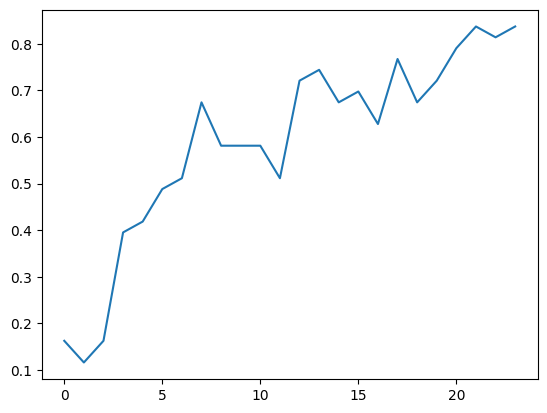

In [6]:
from matplotlib import pyplot as plt

# Load the model from the database
model = db.load('model', model.identifier)

# Plot the accuracy values
plt.plot(model.trainer.metric_values['my-valid/acc'])
plt.show()